# Рынок заведений общественного питания Москвы 

Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Мы — гуру аналитики, и партнёры просят нас подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания в Москве.

## Предварительный осмотр данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})
import requests

from scipy import stats as st
import math
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')

**Описание данных**

- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест

In [3]:
display(df.info(), df.head(), df.tail(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


,id,object_name,chain,object_type,address,number
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36
15365,222535,Шоколадница,да,кафе,"город Москва, Ходынский бульвар, дом 4",10


,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


Предварительные выводы:
- Проверить данные на неявные дубликаты! Есть названия написанные верхним регистром, в кавычках и так далее
- Проверить на общие дубликаты
- Пропусковв данных нет
- Типы данных столбцов корректны
- Название столбцов корректны по грамматике, но некоторые (number) не корректно отражают смысл данных в них
- Минимальное количество посадочных мест 0, а максимальное 1700? Стоит обдумать реальность таких чисел

## Предобработка данных

Заменим на корректное название столбец `number`. В столбце `chain` заменим `да` и `нет` на понятные `сетевое` и `несетевое`

In [4]:
df = df.rename(columns={'number':'number_of_seats'})
df['chain'] = df['chain'].map({'нет':'несетевое','да':'сетевое'})

Приведём к нижнему регистру все значения в столбцах `object_name` и `address`

In [5]:
df['object_name'] = df['object_name'].str.lower()
df['address'] = df['address'].str.lower()

Отфильтруем данные в этих же столбцах. Уберём кавычки, точки, запятые и так далее

In [6]:
symbols = [',', '«', '»', '(', ')', '"', '  ']

In [7]:
for s in symbols:
    df['object_name'] = df['object_name'].str.replace(s, ' ')
    df['address'] = df['address'].str.replace(s, ' ')

А так же заменим все буквы `ё` на `е`

In [8]:
df['address'] = df['address'].str.replace('ё','е')

Посмотрим на уникальные данные  в столбцах `chain` и `objiect_type`

In [9]:
df['chain'].unique()

array(['несетевое', 'сетевое'], dtype=object)

Здесь всё корректно. Либо сетевое, либо нет, третьего не дано

In [10]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Да, здесь присутствуют похожие по сути кафе и кафетерий, столовая и закусочная. Но всё же это разные типы заведений, не будем ничего объединять. \
Только заменим длинные названия более удобными для понимания

In [11]:
df['object_type'] = df['object_type'].str.replace('предприятие быстрого обслуживания', 'фаст-фуд')
df['object_type'] = df['object_type'].str.replace('магазин \(отдел кулинарии\)', 'кулинария')

Посчитаем пропуски

In [12]:
df.isna().sum()

id                 0
object_name        0
chain              0
object_type        0
address            0
number_of_seats    0
dtype: int64

Посчитаем дубликаты

In [13]:
df.duplicated().sum()

0

**Итог**: \
Почистили данные, проверили на дубликат и пропуски. Заменили название одного столбца, некоторые данные в таблице так же заменили для удобства. Проверили на уникальность. Можно переходить к анализу данных. \
P.S. Что касается максимального и минимального колчества посадочных мест в заведениях: 0 - реален, это может быть рюмочная, ларёк быстрого питания и др., 1700 - тоже возможно, тем более в столице. Оставим как есть. \
Перейдём к анализу данных

In [14]:
del df['id']

In [15]:
df.duplicated().sum()

85

Появилось 85 дубликатов. Причины появления дубликатов:
- изначально в таблицу были внесены одинаковые заведения. просто им присвоились разные id
- при нашей "чистке" изначально разные строки стали одинаковыми (заглавные буквы стали строчными, буквы Ё заменились на Е, пропали кавычки, запятые и так далее) \
В любом случае мы имеем заведения с одинаковыми названиями, адресами, количеством посадочных мест. \
Их нужно удалить.

In [16]:
df = df.drop_duplicates()

## Анализ данных

### Исследуем соотношение видов объектов общественного питания по количеству

Сначала посмотрим на количество посадочных мест. Сгруппируем данные. Построим график

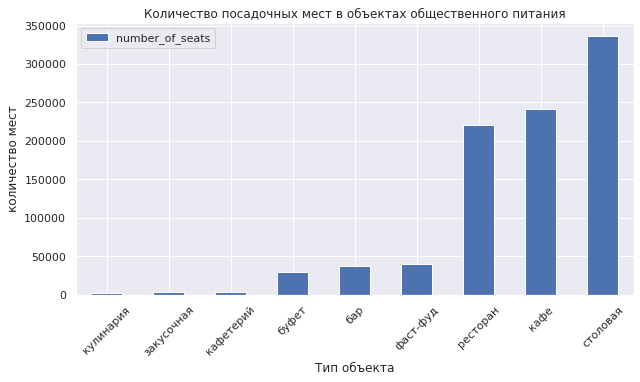

In [17]:
сount_number_seats_by_type = df.groupby('object_type').sum().reset_index()
ax = (сount_number_seats_by_type[['object_type', 'number_of_seats']]\
      .set_index('object_type')\
      .sort_values('number_of_seats', ascending=True)\
      .plot(kind='bar'))
ax.set_xlabel('Тип объекта')
ax.set_ylabel('количество мест')
ax.set_title('Количество посадочных мест в объектах общественного питания')
plt.xticks(rotation=45)
plt.show()

А теперь посчитаем по количеству заведения на каждый тип

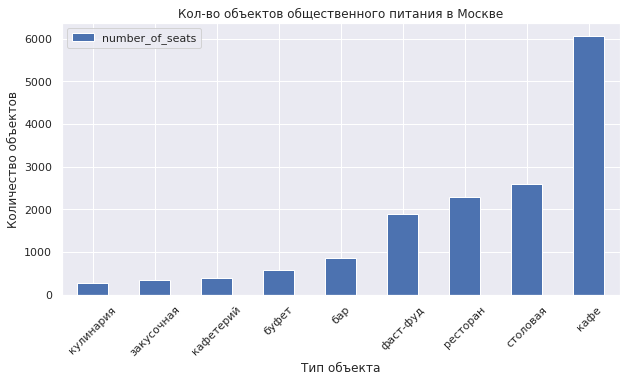

In [18]:
count_by_type = df.groupby('object_type').count().reset_index()
ax = (count_by_type[['object_type', 'number_of_seats']]\
      .set_index('object_type')\
      .sort_values('number_of_seats', ascending=True)\
      .plot(kind='bar'))
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Количество объектов')
ax.set_title('Кол-во объектов общественного питания в Москве')
plt.xticks(rotation=45)
plt.show()

**Выводы**:
- Кафе (как тип заведения) в Москве больше всего
- Столовые рестораны и фаст-фуды находятся примерно на одном уровне по количеству заведений
- А вот по количеству посадочных мест лидируют столовые. Кафе и рестораны разделяют второе место 

### Исследуем соотношение сетевых и несетевых заведений по количеству. Построим график

Сгруппируем данные. Построим график.

In [19]:
df.groupby('chain')['object_name'].count().sort_values()

chain
сетевое       2964
несетевое    12317
Name: object_name, dtype: int64

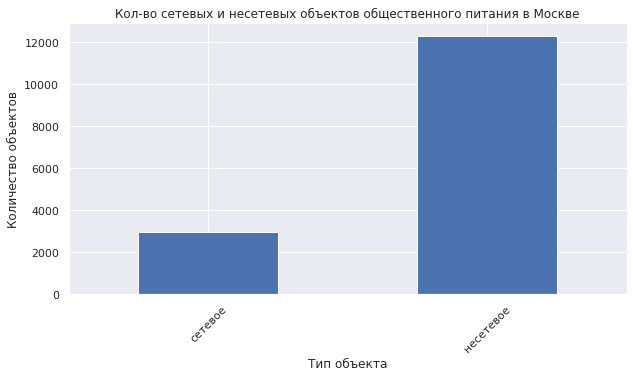

In [20]:
ax = df.groupby('chain')['object_name'].count().sort_values().plot(kind='bar')
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Количество объектов')
ax.set_title('Кол-во сетевых и несетевых объектов общественного питания в Москве')
plt.xticks(rotation=45)
plt.show()

Несетевых заведений в Москве больше, чем сетевых. Более, чем в 4 раза

### Для какого вида объекта общественного питания характерно сетевое распространение?

Составим сводную таблицу по типу объкта и по сетевому признаку

In [21]:
df_1 = (
        pd.pivot_table(df, index = 'object_type', columns = 'chain', values ='object_name', aggfunc = 'count'))
df_1

chain,несетевое,сетевое
object_type,,
бар,818,37
буфет,565,11
закусочная,292,56
кафе,4675,1396
кафетерий,343,52
кулинария,195,78
ресторан,1739,543
столовая,2581,3
фаст-фуд,1109,788


Посчитаем процентное соотношение сетевых заведений к общему их числу 

In [22]:
df_1['chain'] = round(df_1['сетевое']/(df_1['сетевое'] + df_1['несетевое'])*100,2)
df_1.sort_values('chain',ascending = False)

chain,несетевое,сетевое,chain
object_type,,,
фаст-фуд,1109,788,41.54
кулинария,195,78,28.57
ресторан,1739,543,23.79
кафе,4675,1396,22.99
закусочная,292,56,16.09
кафетерий,343,52,13.16
бар,818,37,4.33
буфет,565,11,1.91
столовая,2581,3,0.12


Лидер сетевого размещения - фаст-фуд. Кулинарии, рестораны и кафе разделяют второе место

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Оставим в данныз только сетевые заведения

In [23]:
chain_cafe = df.query('chain == "сетевое"')

Сгруппируем данные по названию сети. Посчитаем их количество и медианное количество посадочных мест 

In [24]:
chain_cafe = chain_cafe.groupby('object_name').agg({'object_name':'count','number_of_seats':'median'})
chain_cafe

,object_name,number_of_seats
object_name,,
кафе кулинарная лавка братьев караваевых,2,9.0
beverly hills diner,1,88.0
bierloga,1,75.0
black & white,1,40.0
bocconcino,3,68.0
...,...,...
ямми микс,1,2.0
ян примус,1,300.0
японский ресторан ваби-саби,1,155.0


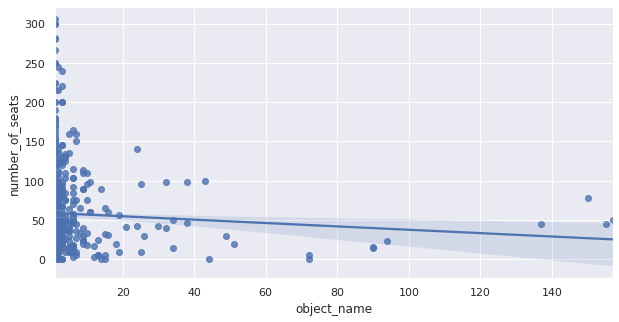

In [25]:
sns.regplot(x=chain_cafe["object_name"], y=chain_cafe["number_of_seats"])
plt.show()

**Ответ на вопрос**: Приоритетная ситуация для сетей - много посадочных мест, мало заведений

### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

Бостроим боксплоты по типам заведений по количеству посадочных мест в каждом 

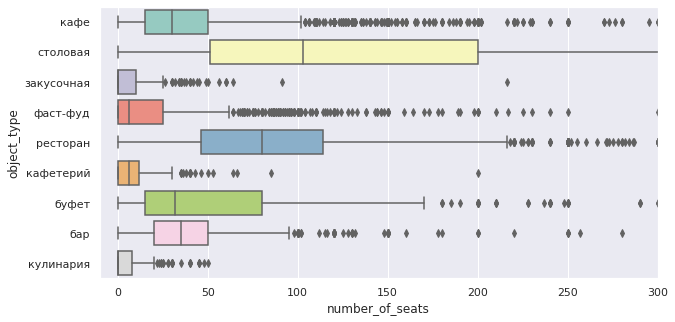

In [26]:
ax = sns.boxplot(x='number_of_seats', y='object_type', data=df, palette="Set3")
ax.set_xlim(-10,300)
plt.show()

In [27]:
df.groupby('object_type')['number_of_seats'].describe().sort_values(by='50%')

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
закусочная,348.0,7.847701,16.884497,0.0,0.0,0.0,10.0,216.0
кулинария,273.0,5.589744,9.872729,0.0,0.0,0.0,8.0,50.0
кафетерий,395.0,9.184810,14.677023,0.0,0.0,6.0,12.0,200.0
фаст-фуд,1897.0,20.808645,38.563004,0.0,0.0,6.0,25.0,580.0
кафе,6071.0,39.785703,37.751163,0.0,15.0,30.0,50.0,533.0
буфет,576.0,51.425347,56.512850,0.0,15.0,32.0,80.0,320.0
бар,855.0,43.533333,67.112342,0.0,20.0,35.0,50.0,1700.0
ресторан,2282.0,96.884750,94.781446,0.0,46.0,80.0,114.0,1500.0
столовая,2584.0,130.337848,95.189104,0.0,51.5,103.0,200.0,1400.0


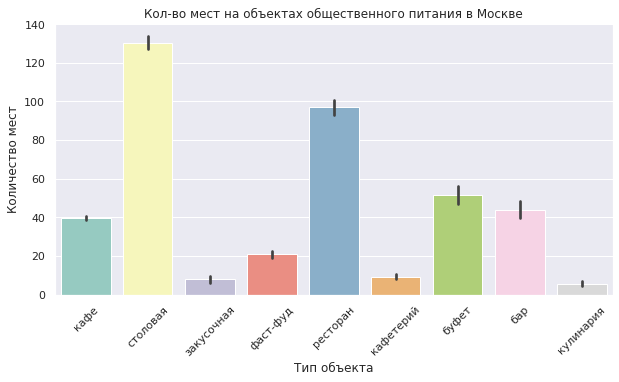

In [28]:
ax = sns.barplot(x='object_type', y='number_of_seats', data=df, palette="Set3")
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Количество мест')
ax.set_title('Кол-во мест на объектах общественного питания в Москве')
plt.xticks(rotation=45)
plt.show()

Лидер по среднему количеству посадочных мест - столовая. На втором месте - ресторан. Третье разделяют - кафе, бар и буфет

### Выделите в отдельный столбец информацию об улице из столбца address

Выделяем в отдельную переменную названия всех улиц

In [29]:
streets = df['address'].to_list()

"Пройдёмся" по всем адресам. Название улицы находится между названием города( Москвы) и дома

In [30]:
streets_only = []
for street in streets:  
    start = street.find('город москва')
    end = street.find('дом')
    streets_only.append(street[start+13:end-1])

Добавим отдельный столбец с названием улицы

In [31]:
df['street_name'] = streets_only

Проверим данные

In [32]:
df.head(15)

,object_name,chain,object_type,address,number_of_seats,street_name
0,сметана,несетевое,кафе,город москва улица егора абакумова дом 9,48,улица егора абакумова
1,родник,несетевое,кафе,город москва улица талалихина дом 2/1 корпус 1,35,улица талалихина
2,кафе академия,несетевое,кафе,город москва абельмановская улица дом 6,95,абельмановская улица
3,пиццетория,сетевое,кафе,город москва абрамцевская улица дом 1,40,абрамцевская улица
4,кафе вишневая метель,несетевое,кафе,город москва абрамцевская улица дом 9 корпус 1,50,абрамцевская улица
5,стол. при гоу сош № 1051,несетевое,столовая,город москва абрамцевская улица дом 15 корпус 1,240,абрамцевская улица
6,брусника,сетевое,кафе,город москва переулок сивцев вражек дом 6/2,10,переулок сивцев вражек
7,буфет мтуси,несетевое,столовая,город москва авиамоторная улица дом 8 строение 1,90,авиамоторная улица
8,кпф семья-1,несетевое,столовая,город москва авиамоторная улица дом 8 строение 1,150,авиамоторная улица
9,столовая мтуси,несетевое,столовая,город москва авиамоторная улица дом 8 строение 1,120,авиамоторная улица


### Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Сгруппируем данные

In [33]:
top_streets = (df.groupby('street_name')\
               .count()\
               .sort_values(by='object_type', ascending=False)\
               .head(10)\
               .reset_index())
top_10 = list(top_streets['street_name'])
top_streets

,street_name,object_name,chain,object_type,address,number_of_seats
0,проспект мира,203,203,203,203,203
1,профсоюзная улица,181,181,181,181,181
2,ленинградский проспект,169,169,169,169,169
3,пресненская набережная,167,167,167,167,167
4,варшавское шоссе,155,155,155,155,155
5,ленинский проспект,147,147,147,147,147
6,проспект вернадского,127,127,127,127,127
7,кутузовский проспект,114,114,114,114,114
8,каширское шоссе,103,103,103,103,103
9,ходынский бульвар,102,102,102,102,102


Построим график

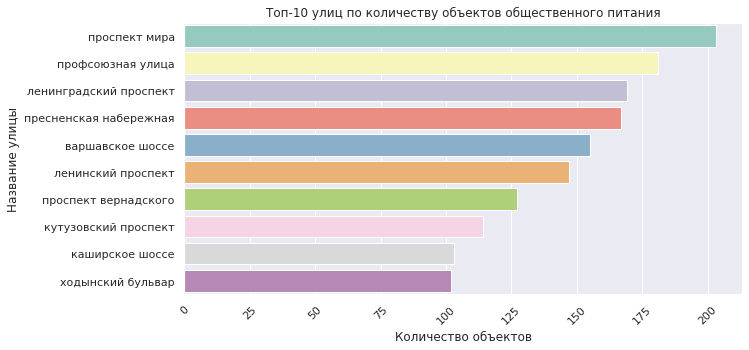

In [34]:
ax = sns.barplot(x='object_type', y='street_name', data=top_streets, palette="Set3")
ax.set_xlabel('Количество объектов')
ax.set_ylabel('Название улицы')
ax.set_title('Топ-10 улиц по количеству объектов общественного питания')
plt.xticks(rotation=45)
plt.show()

Подгрузим внешнюю таблицу и почистим данные

In [35]:
area = pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv?sequence=1&isAllowed=y')
area = area.rename(columns={'streetname':'street_name'})
area['street_name'] = area['street_name'].str.lower()
area

,street_name,areaid,okrug,area
0,выставочный переулок,17,ЦАО,Пресненский район
1,улица гашека,17,ЦАО,Пресненский район
2,большая никитская улица,17,ЦАО,Пресненский район
3,глубокий переулок,17,ЦАО,Пресненский район
4,большой гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,вознесенский проезд,17,ЦАО,Пресненский район
4394,волков переулок,17,ЦАО,Пресненский район
4395,поварская улица,17,ЦАО,Пресненский район
4396,кудринская площадь,17,ЦАО,Пресненский район


In [36]:
top_streets = top_streets.merge(area, how = 'left' ,on= 'street_name')

In [37]:
top_streets

,street_name,object_name,chain,object_type,address,number_of_seats,areaid,okrug,area
0,проспект мира,203,203,203,203,203,70,СВАО,Алексеевский район
1,проспект мира,203,203,203,203,203,86,СВАО,Ярославский Район
2,проспект мира,203,203,203,203,203,78,СВАО,Район Марьина роща
3,проспект мира,203,203,203,203,203,79,СВАО,Останкинский район
4,проспект мира,203,203,203,203,203,81,СВАО,Район Ростокино
5,проспект мира,203,203,203,203,203,82,СВАО,Район Свиблово
6,проспект мира,203,203,203,203,203,16,ЦАО,Мещанский район
7,профсоюзная улица,181,181,181,181,181,123,ЮЗАО,Академический район
8,профсоюзная улица,181,181,181,181,181,132,ЮЗАО,Район Черемушки
9,профсоюзная улица,181,181,181,181,181,134,ЮЗАО,Район Ясенево


In [38]:
top_streets['area'].unique()

array(['Алексеевский район', 'Ярославский Район', 'Район Марьина роща',
       'Останкинский район', 'Район Ростокино', 'Район Свиблово',
       'Мещанский район', 'Академический район', 'Район Черемушки',
       'Район Ясенево', 'Район Коньково', 'Обручевский район',
       'Район Теплый Стан', 'Район Аэропорт', 'Район Беговой',
       'Хорошевский район', 'Район Сокол', 'Пресненский район',
       'Район Чертаново Центральное', 'Район Чертаново Северное',
       'Район Чертаново Южное', 'Донской район',
       'Район Нагатино-Садовники', 'Нагорный район',
       'Район Северное Бутово', 'Район Южное Бутово',
       'Район Проспект Вернадского', 'Район Тропарево-Никулино',
       'Район Гагаринский', 'Ломоносовский район', 'Район Якиманка',
       'Район Раменки', 'Район Дорогомилово', 'Район Фили-Давыдково',
       'Район Москворечье-Сабурово', 'Район Орехово-Борисово Южное',
       'Район Орехово-Борисово Северное'], dtype=object)

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Посчитаем количество улиц с одним заведением

In [39]:
temp = df.groupby('street_name').count().reset_index()
len(temp.query('object_name == 1'))

814

Оставим в таблице только улицы с 1 заведением 

In [40]:
street_1_cafe = temp.query('object_name == 1').reset_index()

Соединим 2 таблицы по названию улицы

In [41]:
street_1_cafe = area.merge(street_1_cafe, on = 'street_name')
street_1_cafe

,street_name,areaid,okrug,area,index,object_name,chain,object_type,address,number_of_seats
0,улица анатолия живова,17,ЦАО,Пресненский район,1705,1,1,1,1,1
1,средний кондратьевский переулок,17,ЦАО,Пресненский район,1541,1,1,1,1,1
2,малый конюшковский переулок,17,ЦАО,Пресненский район,936,1,1,1,1,1
3,переулок красина,17,ЦАО,Пресненский район,1153,1,1,1,1,1
4,красногвардейский бульвар,17,ЦАО,Пресненский район,821,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
530,звонарский переулок,16,ЦАО,Мещанский район,703,1,1,1,1,1
531,нижний кисельный переулок,16,ЦАО,Мещанский район,1026,1,1,1,1,1
532,малая переяславская улица,16,ЦАО,Мещанский район,916,1,1,1,1,1
533,садовая-сухаревская улица,16,ЦАО,Мещанский район,1459,1,1,1,1,1


Найдём топ-10 районов по расположению улиц с 1 заведением

In [42]:
top_okrug = (street_1_cafe.groupby('area')\
             .count()\
             .sort_values(by = 'object_name',ascending = False)\
             .head(10).reset_index())
top_okrug

,area,street_name,areaid,okrug,index,object_name,chain,object_type,address,number_of_seats
0,Таганский район,27,27,27,27,27,27,27,27,27
1,Район Хамовники,24,24,24,24,24,24,24,24,24
2,Басманный район,21,21,21,21,21,21,21,21,21
3,Тверской район,20,20,20,20,20,20,20,20,20
4,Пресненский район,19,19,19,19,19,19,19,19,19
5,Район Марьина роща,17,17,17,17,17,17,17,17,17
6,Район Арбат,17,17,17,17,17,17,17,17,17
7,Мещанский район,16,16,16,16,16,16,16,16,16
8,Район Сокольники,15,15,15,15,15,15,15,15,15
9,Район Замоскворечье,14,14,14,14,14,14,14,14,14


Больше всего улиц с одним кафе располагается в Таганском районе и Хамовниках. Далее идут Басманный, Тверской и Пресненский районы с примерно одинаковым количеством улиц с одним заведеним 

## Вывод

**Выводы**:
- В Москве больше всего кафе, по сравнению с другии типами заведений
- По общему количеству посадочных мест лидируют столовые 
- Лидер по среднему количеству посадочных мест - столовая. На втором месте - ресторан. Третье разделяют - кафе, бар и буфет
- Несетевых заведений больше сетевых. Более, чем в 4 раза 
- Сетевое размещение более всего хараткерно для фаст-фуда
- Для сетевых заведений характерно много заведений с небольшим числом посадочных мест в каждом
- Больше всего улиц с одним кафе располагается в Таганском районе и Хамовниках. Далее идут Басманный, Тверской и Пресненский районы с примерно одинаковым количеством улиц с одним заведеним 

**Рекомендации**:
- Для нашего будущего кафе точно не подходит сетевое размещение. Роботы - штука затратная
- Кафе, ресторан, бар - приоритетные типы для нашего заведения
- Так как наше кафе будет в единственном, экслюзивном варианте, расположение должно быть с максимальным человекопотоком, в центре. Да, придётся вложится в аренду, но нам нужны лучшие клиенты!)
- Роботы круто! Но клиентов нужно будет чем-то удерживать , чтобы они превращались в постоянных. Не забывать про основу заведений общественного ПИТАНИЯ- это кухня!
